In this project Amazon reviews are classified according to their star rating. In this notebook review summaries are encoded using __Small-Bert__ based on the Transformer architecture. The encodings are then used in a downstream task for classifying the reviews. Classification accuracy is then evaluated.
The performance of this model can be compared to the non-transformer model trained using one-hot encoding and an n-grams approach and the model trained on entire reviews. 

In [2]:
import json
import gzip
import pandas as pd
import numpy as np 
import tensorflow as tf 
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.manifold import TSNE
from keras.callbacks import EarlyStopping

Opened the json.gz file and loaded its contents into a pandas dataframe. Then the dataframe is shuffled and split into train , test and validation sets.

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(r"C:\Users\rishi\ml_projects\reviews\Video_Games.json.gz")
df=df.drop(["reviewTime","reviewerID","vote","style","image","unixReviewTime","reviewerName"],axis=1)
df=shuffle(df)
df=df.reset_index(drop=True)
df=df[:30000]
df['overall']=df['overall'].apply(lambda x: float(x))
df['reviewText']=df['reviewText'].apply(lambda x: str(x))
df['summary']=df['summary'].apply(lambda x: str(x))
train,valid,test=df[:1000], df[2000:2100], df[2200:2300]


On examination of the data, it has a reviewText column with the entire review of each product and a summary column with the summary of the review.

In [4]:
train.head(10)

,overall,verified,asin,reviewText,summary
0,5.0,True,B0045ZIENQ,"Great game, low price.",Five Stars
1,5.0,True,B00029QOQ8,I love this game!,Two Stars
2,5.0,True,B00GAC1D2G,Easy,Gift
3,5.0,True,B017W16ZJE,Very nice thank you,Five Stars
4,5.0,True,B009716KJS,Price was great and sipping was fast. Items we...,perfect
5,5.0,True,B00006IL3C,Great case,Five Stars
6,5.0,True,B00FNKMVUO,Bought as a Christmas present,Christmas is coming
7,5.0,False,B00DJYKAPY,"I have never attended a Zumba class, but I hav...",Best One Yet!
8,3.0,True,B00ZM4L7LU,"Its a good game i just wish it had ""drop ins"" ...","good game, i switched over from FIFA"
9,5.0,True,B00L2FGSFI,Nice to have,Five Stars


Batches of multi-sentence review summaries are created for further processing

In [5]:
textsamples=train["summary"]
validsamples=valid["summary"]
testsamples=test["summary"]

textsa=[]
validsa=[]
testsa=[]
textsamples.apply(lambda x: textsa.append(x))
textsamples=tf.constant(textsa)
validsamples.apply(lambda x: validsa.append(x))
validsamples=tf.constant(validsa)
testsamples.apply(lambda x: testsa.append(x))
testsamples=tf.constant(testsa)


Pre-trained Small-Bert is loaded from Tensorflow-hub.

In [6]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

The text is embedded using small-bert. Here each summary is embedded as a vector with shape (512,)

In [7]:
embedding_model=keras.Model(text_input,[pooled_output])
embedded_text=embedding_model(textsamples)
valid_text=embedding_model(validsamples)
test_text=embedding_model(testsamples)

Creating Tensorflow datasets from the embeddings and labels. The datasets are split into batches of 32 samples

In [8]:
train_set=tf.data.Dataset.from_tensor_slices((embedded_text,train['overall'][:20000]))
valid_set=tf.data.Dataset.from_tensor_slices((valid_text,valid['overall']))
test_set=tf.data.Dataset.from_tensor_slices((test_text,test['overall']))
batchsize=32
train_set=train_set.map(lambda x, y:(x,int(y)-1))
valid_set=valid_set.map(lambda x, y:(x,int(y)-1))
test_set=test_set.map(lambda x, y:(x,int(y)-1))
train_set=train_set.batch(batchsize)
valid_set=valid_set.batch(batchsize)
test_set=test_set.batch(batchsize)
for ele in train_set:
    print(ele)
    break

(<tf.Tensor: shape=(32, 512), dtype=float32, numpy=
array([[ 0.93639857,  0.08098646,  0.271271  , ...,  0.42630538,
        -0.37614208, -0.918494  ],
       [ 0.97797513, -0.40882117,  0.19902502, ...,  0.2079256 ,
        -0.3268794 , -0.8421278 ],
       [ 0.9128456 ,  0.7539295 ,  0.17689598, ...,  0.2051565 ,
        -0.55331165, -0.61668634],
       ...,
       [ 0.9965202 ,  0.12178351,  0.11051706, ...,  0.27734283,
        -0.17783454, -0.4026886 ],
       [ 0.99381155, -0.33894342, -0.17123672, ...,  0.1921483 ,
        -0.43867472, -0.97398776],
       [ 0.991642  ,  0.5460511 ,  0.03046118, ...,  0.06493562,
        -0.2687157 ,  0.03926307]], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 0, 3, 4, 4, 4, 3, 1, 4, 3,
       3, 4, 4, 4, 4, 4, 4, 3, 0, 4])>)


Visualizing the review embeddings. In contrast to the full review embeddings, there are visible clusters of 5 star ratings and 1 star ratings, but most of the summaries have no visible pattern.

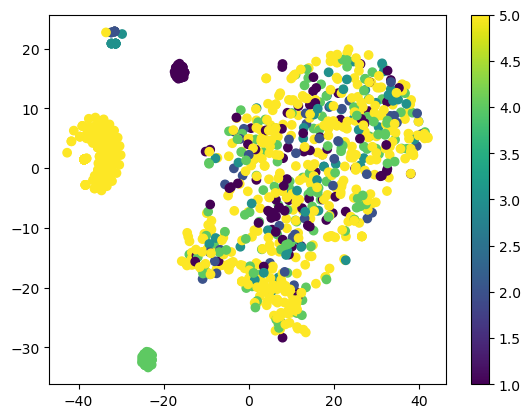

In [9]:
labels=np.array(train['overall'])
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embedded_text)
plt.scatter(embeddings_tsne[:,0],embeddings_tsne[:,1],c=labels)
plt.colorbar()
plt.show()

A neural network is built and trained on the embeddings.

In [115]:
inputs=keras.Input(shape=(512,))
features=layers.Dense(1024,activation='relu')(inputs)
outputs=layers.Dense(5,activation='softmax')(features)
earlystopping=EarlyStopping(monitor="val_accuracy",mode="max",patience=10,restore_best_weights=True)
model=keras.Model(inputs,outputs)
model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 512)]             0         
                                                                 
 dense_56 (Dense)            (None, 1024)              525312    
                                                                 
 dense_57 (Dense)            (None, 5)                 5125      
                                                                 


Total params: 530,437
Trainable params: 530,437
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
watch=model.fit(train_set,epochs=35,validation_data=valid_set,callbacks=[earlystopping])

Epoch 1/35


32/32 [==============================] - 1s 9ms/step - loss: 1.3369 - accuracy: 0.5530 - val_loss: 1.0403 - val_accuracy: 0.6000
Epoch 2/35
32/32 [==============================] - 0s 6ms/step - loss: 0.9844 - accuracy: 0.6470 - val_loss: 0.9762 - val_accuracy: 0.6400
Epoch 3/35
32/32 [==============================] - 0s 5ms/step - loss: 0.9135 - accuracy: 0.6720 - val_loss: 0.9732 - val_accuracy: 0.6300
Epoch 4/35
32/32 [==============================] - 0s 5ms/step - loss: 0.8571 - accuracy: 0.6900 - val_loss: 0.9593 - val_accuracy: 0.6500
Epoch 5/35
32/32 [==============================] - 0s 5ms/step - loss: 0.7955 - accuracy: 0.7060 - val_loss: 0.9510 - val_accuracy: 0.6500
Epoch 6/35
32/32 [==============================] - 0s 5ms/step - loss: 0.7423 - accuracy: 0.7200 - val_loss: 0.9437 - val_accuracy: 0.6900
Epoch 7/35
32/32 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.7460 - val_loss: 0.9660 - val_accuracy: 0.6900
Epoch 8/35
32/32 [=============

Plot of the validation accuracy and validation loss

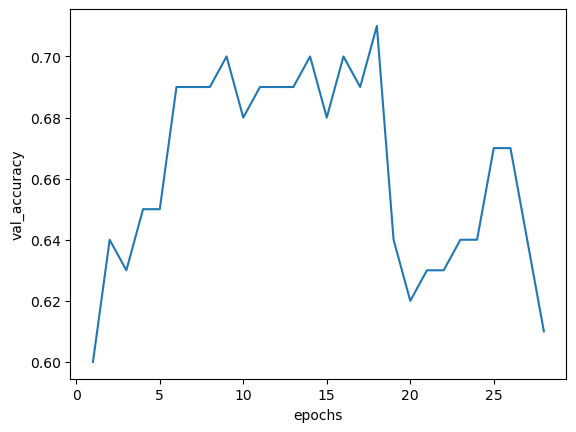

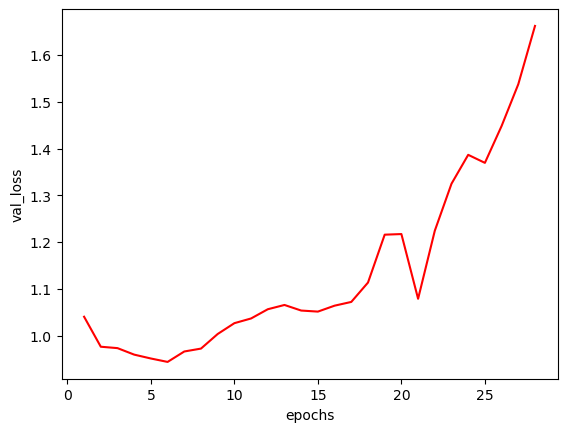

In [117]:
historydict=watch.history
val_accuracy=historydict['val_accuracy']
epochs=range(1,len(val_accuracy)+1)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.plot(epochs,val_accuracy)
fig2=plt.figure()
plt.plot(epochs,historydict['val_loss'],'r')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.show()

The models accuracy is evaluated on the test set. This performs better than the model trained on entire reviews.

In [118]:
y_predictions=model.predict(test_set)
finalpred=[]
for row in y_predictions:
    finalpred.append(np.argmax(row)+1)
finalpred=np.array(finalpred)
actual=test['overall'].apply(lambda x: int(x))
actual=np.array(actual)

4/4 [==============================] - 0s 5ms/step


In [119]:
def calc_accuracy(predictions,actual):
    correct=0
    for i in range(0, len(predictions)):
        if(predictions[i]==actual[i]):
            correct+=1
    return correct/len(predictions)
accuracy=calc_accuracy(finalpred,actual)
print(f"accuracy:{accuracy}")

accuracy:0.65
